# Measure variant fitness effect by combining DESeq2 measurements in weighted least squares (WLS) regression

DESeq2 logFC estimates from individual barcodes are fitted into a weighted linear regression to measure variant fitness effects and identify significant GxG interactions.

For each competition, the neutral set barcodes are fitted to estimate the variance in log2FoldChange values at different read depths. New weights are assigned based on the inverse variance from the model. This should make P-values across competitions comparable and preserve statistical power for higher coverage barcodes.

For the remaining oligos in the CRISPEY library, each oligo's barcodes are assigned the weight of its median barcode. This ensures that within each oligo, all barcodes are treated with the same weight. In the WLS regression, the barcodes from multiple oligos are jointly fitted to estimate variant fitness.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.robust.scale import mad
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.formula.api import ols, wls
from statsmodels.stats.multitest import multipletests

In [2]:
working_dir="/home/users/rang/scratch/yeast/crispey3/gxg_5comp_aug2021/"
os.chdir(working_dir)

## Functions

In [3]:
def robust_outlier_removal(umi_df, fc_cutoff=3.5, basemean_cutoff=5):
    '''
    accepts a dataframe of deseq results and removes outliers based on log2FoldChange or baseMean values
    filters log2FoldChange by robust MADs - shrinks variance in logFC values
    filters baseMean by simple X-fold cutoff above median - reduces dependence on high leverage barcodes
    adjust cutoffs as necessary
    '''
    if len(umi_df)==1:
        return umi_df
    
    indices = umi_df.index.values
    fcs = umi_df['log2FoldChange'].values
    fc_outlier_stats = [abs(i-np.median(fcs))/mad(fcs) for i in fcs]
    basemeans = umi_df['baseMean'].values
#     basemean_outlier_stats = [abs(i-np.median(basemeans))/mad(basemeans) for i in basemeans]
    basemean_outlier_stats = [(i-np.median(basemeans))/np.median(basemeans) for i in basemeans]
    
    outliers = []
    for i in range(len(indices)):
        if fc_outlier_stats[i]>fc_cutoff or basemean_outlier_stats[i]>basemean_cutoff:
            outliers.append(indices[i])
    
    return umi_df.drop(outliers)

def calc_var_fitness(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks if the variant fitness effect 
    is significantly different from neutral in each condition (i.e. genotype/environment)
    '''
    # prep input
    conditions = sorted(conditions)
    test_names = []
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    for cond in conditions:
        # test if variant fitness effect is significantly different from zero
        test_names.append('{0},{1}'.format(v, cond))
        v_cond_cov = [c for c in v_cond_interactions if cond in c]
        # no interaction term if reference condition, else add interaction
        if len(v_cond_cov)==0: 
            hyp.append('{}=0'.format(v_cov))
        else:
            hyp.append('{}+{}=0'.format(v_cov, v_cond_cov[0])) # assumes each non-reference condition has only 1 term to add to calc fitness
    
    hyp = ','.join(hyp)
    
    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)

def calc_cond_interactions(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks between all conditions for significant interactions
    '''
    # prep input
    conditions = sorted(conditions)
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    test_names = []
    
    for i in range(len(conditions)-1):
        cond1 = conditions[i]
        v_cond1_cov = [c for c in v_cond_interactions if cond1 in c]
        if len(v_cond1_cov) == 0:
            v_cond1_cov = 0
        else:
            v_cond1_cov = v_cond1_cov[0]
        for j in range(i+1, len(conditions)):
            cond2 = conditions[j]
            v_cond2_cov = [c for c in v_cond_interactions if cond2 in c]
            if len(v_cond2_cov) == 0:
                v_cond2_cov = 0
            else:
                v_cond2_cov = v_cond2_cov[0]

            # add hypothesis test
            hyp.append('{0}={1}'.format(v_cond1_cov, v_cond2_cov))
            # add test name
            test_names.append('{0}:{1}-{2}'.format(v, cond1, cond2))

    hyp = ','.join(hyp)

    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)


## File paths

In [4]:
# counts
counts_file = "./counts/barcode_counts.txt"

# samples file
samples_file = "gxg_5comp_aug2021_samples.txt"

# neutral barcodes
neutral_barcodes_file = "/home/users/rang/crispey3/library_design/Output/crispey3_neutral_oligos_only.txt"

# oligo design table
oligo_design_file = "/home/users/rang/crispey3/library_design/Output/oligos_nonuniq_crispey3_GG_9bp_OLIGO.txt"

# ladder oligos annotations
ladder_annotations_file = "/home/users/rang/crispey3/ladder_pilot_feb2021/ladder_oligos_annotated.txt"

# deseq results
deseq_results_list = sorted([os.path.abspath(x) for x in glob.glob("./deseq/gxg_5comp_aug2021_*_results.txt")])
display(deseq_results_list)

# output paths
output_dir = "./fitness/"
os.makedirs(output_dir, exist_ok=True)
var_fitness_file = output_dir+"gxg_5comp_aug2021_varFitness_WLSupdated.txt"
gxg_interactions_file = output_dir+"gxg_5comp_aug2021_gxgInteractions_WLSupdated.txt"

['/scratch/users/rang/yeast/crispey3/gxg_5comp_aug2021/deseq/gxg_5comp_aug2021_bya_results.txt',
 '/scratch/users/rang/yeast/crispey3/gxg_5comp_aug2021/deseq/gxg_5comp_aug2021_byb_results.txt',
 '/scratch/users/rang/yeast/crispey3/gxg_5comp_aug2021/deseq/gxg_5comp_aug2021_rm_results.txt',
 '/scratch/users/rang/yeast/crispey3/gxg_5comp_aug2021/deseq/gxg_5comp_aug2021_yjm_results.txt',
 '/scratch/users/rang/yeast/crispey3/gxg_5comp_aug2021/deseq/gxg_5comp_aug2021_yps_results.txt']

## Load DESeq2 results, filter outliers
Robust leave-one-out approach to remove outlier barcodes for each oligo

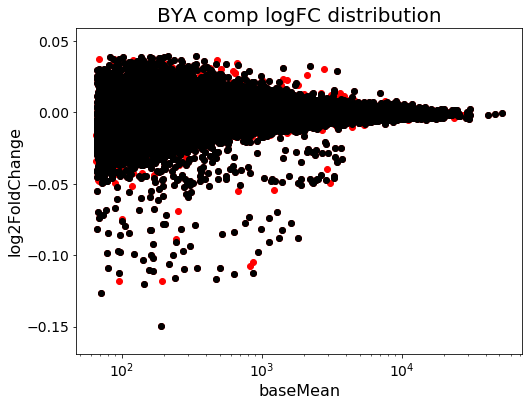

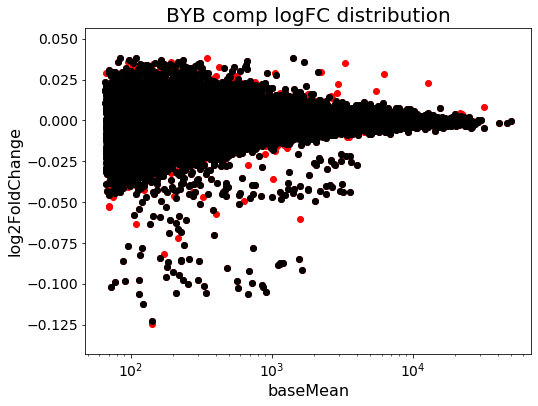

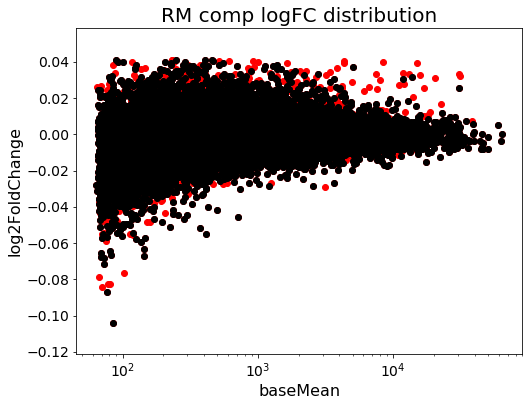

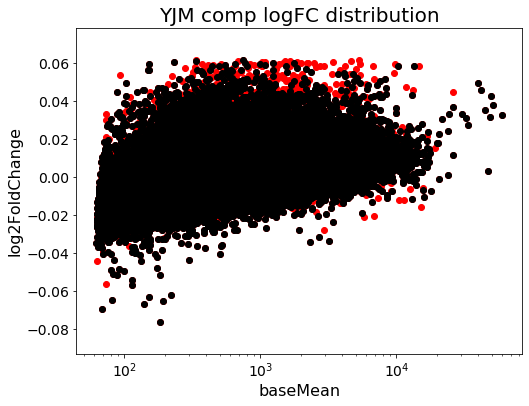

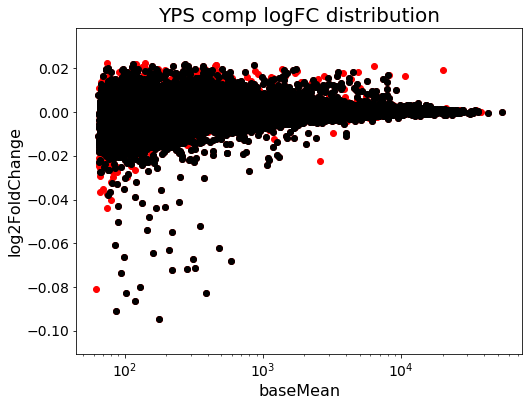

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geno,barcode_id
barcode,,,,,,,,
003_029-4,290.999479,-0.013945,0.002296,-6.074036,1.247347e-09,7.388190e-09,BYA,003_029
003_029-3,1063.658537,0.006716,0.001427,4.707484,2.507930e-06,8.811894e-06,BYA,003_029
003_029-5,190.778375,-0.016766,0.004642,-3.611546,3.043772e-04,7.449685e-04,BYA,003_029
003_029-1,666.111374,-0.002887,0.001961,-1.471997,1.410218e-01,1.906287e-01,BYA,003_029
003_029-2,454.032245,-0.002281,0.001602,-1.423823,1.544978e-01,2.068170e-01,BYA,003_029
...,...,...,...,...,...,...,...,...
Ladder_040-3,2436.815431,-0.000017,0.000790,-0.021236,9.830570e-01,9.914055e-01,YPS,Ladder_040
Ladder_040-4,1022.541664,0.000028,0.002045,0.013852,9.889481e-01,9.943507e-01,YPS,Ladder_040
Ladder_041-2,162.124757,-0.023504,0.003758,-6.255140,3.971599e-10,2.404203e-08,YPS,Ladder_041


In [5]:
# load samples info
samples_df = pd.read_csv(samples_file, sep='\t', header=0, index_col=0)

# load neutral barcodes info
neutral_barcodes_df = pd.read_csv(neutral_barcodes_file, sep='\t', header=0, index_col='barcode_id')

# load counts
counts_df = pd.read_csv(counts_file, sep='\t', header=0, index_col=0)
counts_df = counts_df[samples_df.index]

# load all DESeq2 results
deseq_results_df = []
for file in deseq_results_list:
    geno = file.split('_')[-2].upper() # extract genotype from filename
    df = pd.read_csv(file, sep='\t', header=0, index_col=0)
    df.index.name = 'barcode'
    df['geno'] = geno
    # identify oligo by barcode prefix
    df['barcode_id'] = [x.split('-')[0] for x in df.index]
    
    # plot logFC distribution
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter('baseMean', 'log2FoldChange', data=df, c='r')
    
    # keep oligos represented by 3 or more barcodes
    df = df.groupby('barcode_id').filter(lambda x: len(x)>=3)
    
    # remove outlier barcodes for each oligo
    df = df.groupby('barcode_id').apply(robust_outlier_removal).reset_index(level=0, drop=True)
    
    # replot logFC distribution
    ax.scatter('baseMean', 'log2FoldChange', data=df, c='k')
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('log2FoldChange', fontsize=16)
    ax.set_title('{} comp logFC distribution'.format(geno), fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
    # append to deseq results
    deseq_results_df.append(df)

# assemble final dataframe
deseq_results_df = pd.concat(deseq_results_df, axis=0)
display(deseq_results_df)

In [6]:
# check number of barcodes filtered
for file in deseq_results_list:
    geno = file.split('_')[-2].upper() # extract genotype from filename
    df = pd.read_csv(file, sep='\t', header=0, index_col=0)
    print(geno, len(df), deseq_results_df.geno.value_counts()[geno], deseq_results_df.geno.value_counts()[geno]/len(df))

BYA 20263 19492 0.9619503528598924
BYB 19928 19107 0.9588016860698515
RM 17485 16467 0.941778667429225
YJM 23023 21761 0.9451852495330756
YPS 18221 17219 0.9450085066681302


## Annotate and subset DESeq2 results table

In [7]:
# load oligo design table
oligo_design_df = pd.read_csv(oligo_design_file, sep='\t', header=0, index_col='barcode_id')
annotations_df = oligo_design_df[['var_id', 'guide_id', 'oligo_id']]

# load ladder oligo annotations
ladder_annotations_df = pd.read_csv(ladder_annotations_file, sep='\t', header=0, index_col=0)
ladder_annotations_df['oligo_id'] = ['tech_{}_hdr'.format(orf) for orf in ladder_annotations_df["ORF"]]
ladder_annotations_df['barcode_id'] = ['Ladder_{:0>3}'.format(int(x.split("_")[-1])+1) for x in ladder_annotations_df['Name']]
ladder_annotations_df = ladder_annotations_df[['barcode_id', 'oligo_id']]
# combine information to get complete ladder annotations df with breslow and pilot fitness data
ladder_annotations_df = ladder_annotations_df.merge(annotations_df, on='oligo_id', how='left').drop_duplicates().set_index('barcode_id')
# fill info for barcode "Ladder_40"
ladder_annotations_df.loc['Ladder_040', "var_id"] = "hdr_43"
ladder_annotations_df.loc['Ladder_040', "guide_id"] = "technical_999"

# assemble complete annotations
annotations_df = pd.concat([annotations_df, ladder_annotations_df[annotations_df.columns]])
display(annotations_df.head())

/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (24,25,26,27,28,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,var_id,guide_id,oligo_id
barcode_id,,,
013_001,ERG_00003,guide_1,ergosterol#guide_1#guide_1:REF2ALT:offset14:do...
013_002,ERG_00003,guide_2,ergosterol#guide_2#guide_2:REF2ALT:offset14:do...
021_001,ERG_00004,guide_3,ergosterol#guide_3#guide_3:REF2ALT:offset14:do...
021_002,ERG_00004,guide_4,ergosterol#guide_4#guide_4:REF2ALT:offset14:do...
025_001,EGE_00008,guide_5,ergosterol#guide_5#guide_5:REF2ALT:offset14:do...


In [8]:
# add annotations
deseq_results_df = deseq_results_df.merge(annotations_df[['guide_id', 'oligo_id', 'var_id']], how='inner', left_on='barcode_id', right_index=True)

# subset counts matrix
counts_df = counts_df.query('barcode.isin(@deseq_results_df.index)')

display(deseq_results_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geno,barcode_id,guide_id,oligo_id,var_id
barcode,,,,,,,,,,,
003_029-4,290.999479,-0.013945,0.002296,-6.074036,1.247347e-09,7.388190e-09,BYA,003_029,guide_776,ergosterol#guide_776#guide_776:REF2ALT:offset1...,ERG_00476
003_029-3,1063.658537,0.006716,0.001427,4.707484,2.507930e-06,8.811894e-06,BYA,003_029,guide_776,ergosterol#guide_776#guide_776:REF2ALT:offset1...,ERG_00476
003_029-5,190.778375,-0.016766,0.004642,-3.611546,3.043772e-04,7.449685e-04,BYA,003_029,guide_776,ergosterol#guide_776#guide_776:REF2ALT:offset1...,ERG_00476
003_029-1,666.111374,-0.002887,0.001961,-1.471997,1.410218e-01,1.906287e-01,BYA,003_029,guide_776,ergosterol#guide_776#guide_776:REF2ALT:offset1...,ERG_00476
003_029-2,454.032245,-0.002281,0.001602,-1.423823,1.544978e-01,2.068170e-01,BYA,003_029,guide_776,ergosterol#guide_776#guide_776:REF2ALT:offset1...,ERG_00476
...,...,...,...,...,...,...,...,...,...,...,...
077_032-4,92.049553,0.003747,0.003629,1.032463,3.018554e-01,5.203999e-01,YPS,077_032,guide_5262,gxg#guide_5262#guide_5262:REF2ALT:offset-14:do...,GXG_13299
077_032-1,69.986839,0.003476,0.007340,0.473621,6.357703e-01,7.916065e-01,YPS,077_032,guide_5262,gxg#guide_5262#guide_5262:REF2ALT:offset-14:do...,GXG_13299
191_043-4,203.821879,-0.003149,0.002691,-1.170445,2.418221e-01,4.556998e-01,YPS,191_043,technical_84,tech_YAL040C_scramble,scramble_42


## Visualize mean logFC values of variants
Neutral oligos are excluded from this summary

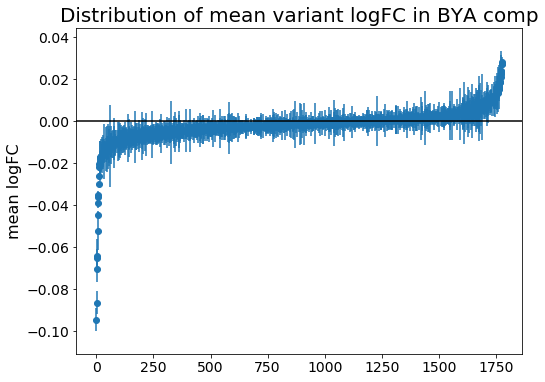

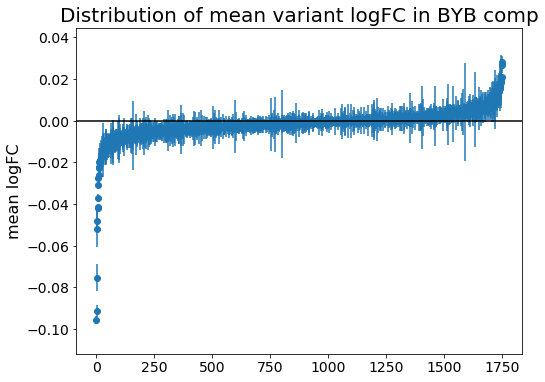

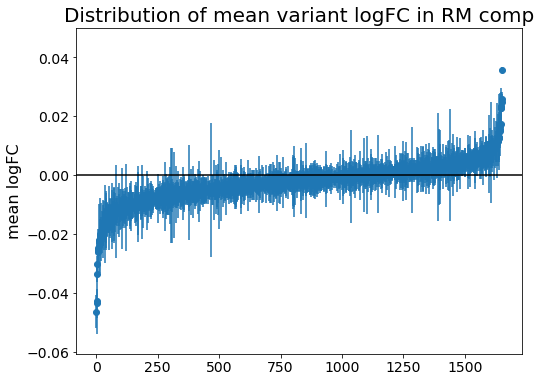

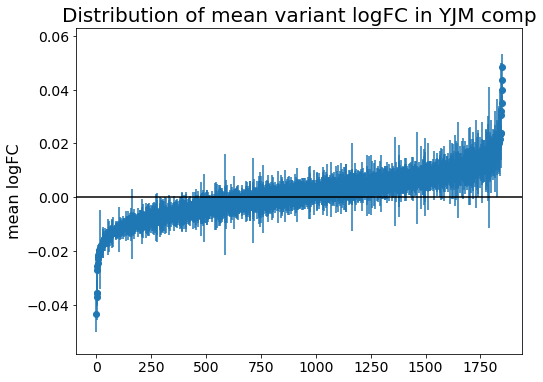

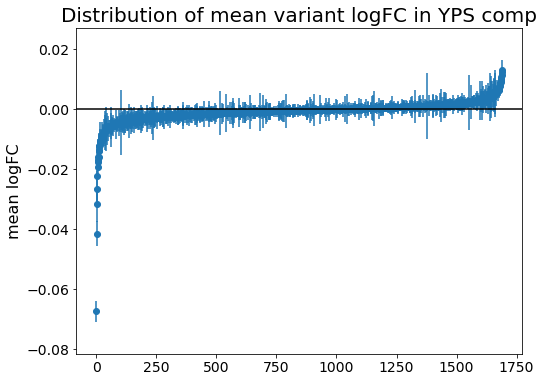

In [9]:
var_summary = deseq_results_df.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby(['geno', 'var_id'])['log2FoldChange'].agg(['mean','sem'])

for g, viz in var_summary.groupby('geno'):
    # plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(np.arange(len(viz)), 'mean', data=viz.sort_values('mean'))
    ax.errorbar(np.arange(len(viz)), 'mean', data=viz.sort_values('mean'), yerr='sem', marker='', linestyle='')
    ax.axhline(0, color='k')
    ax.set_ylabel('mean logFC', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Distribution of mean variant logFC in {} comp'.format(g), fontsize=20)
    plt.show()

### (optional) do t-test on each variant to identify significant fitness effects
The unweighted t-test gives a general idea for how many significant fitness effects to expect from the data. Note that this does not account for heteroscedasticity and should only be used as rough guide to check the WLS output.

In [10]:
test_df = deseq_results_df.query('~barcode_id.isin(@neutral_barcodes_df.index)')
neutral_df = deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)')

# run unweighted t-test for each variant, comparing against neutral barcode distribution
ttest_results = pd.Series()
for l, df in test_df.groupby(['geno', 'var_id']):
    g, var = l
    test = df.query('geno==@g').groupby('var_id').apply(lambda x: ttest_ind(x['log2FoldChange'], neutral_df.query('geno==@g')['log2FoldChange']))
    ttest_results = pd.concat([ttest_results, pd.concat([test], keys=[g])])

ttest_results = pd.DataFrame.from_records(ttest_results, index=ttest_results.index, columns=['t', 'pvalue', 'df'])
ttest_results.index = pd.MultiIndex.from_tuples(ttest_results.index, names=['geno', 'var_id'])
ttest_results['padj'] = multipletests(ttest_results['pvalue'], method='fdr_bh')[1]

# add t-test results to var_summary
var_summary = var_summary.merge(ttest_results, how='inner', left_index=True, right_index=True).sort_values('padj')
display(var_summary.head())

# write t-test results to file
var_summary.to_csv("gxg_5comp_aug2021_ttest_summary.txt", sep='\t', header=True, index=True)

mean       sem          t         pvalue     df  \
geno var_id                                                        
YPS  hdr_10 -0.067340  0.003575 -66.540590   0.000000e+00  802.0   
BYB  hdr_10 -0.095546  0.001959 -55.668138  2.483960e-288  866.0   
BYA  hdr_10 -0.086628  0.005601 -46.965032  8.699223e-243  887.0   
     hdr_37 -0.094724  0.005369 -43.849929  2.823000e-223  877.0   
BYB  hdr_37 -0.091440  0.003224 -42.303030  3.076208e-212  859.0   

                      padj  
geno var_id                 
YPS  hdr_10   0.000000e+00  
BYB  hdr_10  1.083379e-284  
BYA  hdr_10  2.529444e-239  
     hdr_37  6.156257e-220  
BYB  hdr_37  5.366752e-209

## Model log2FoldChange variance in neutral barcodes
These neutral models are used to calculate weights for fitting all barcodes into WLS regression.

Modeling neutral barcodes in BYA


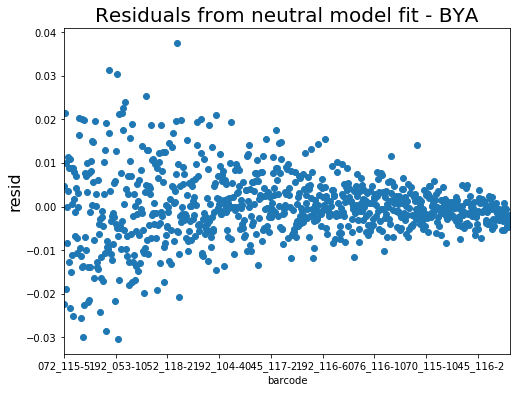

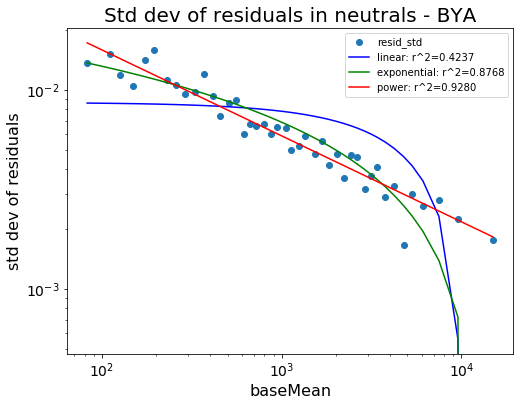

Selected model for BYA: power
Formula: np.log(resid_std) ~ np.log(baseMean)


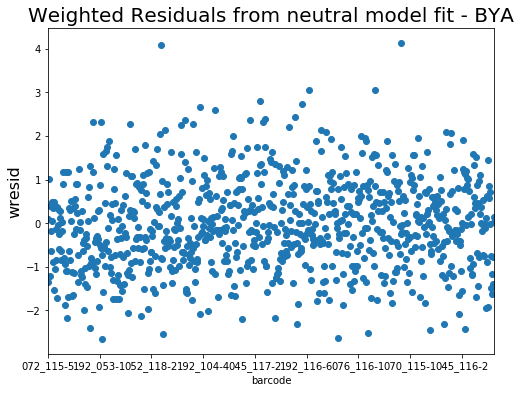

Modeling neutral barcodes in BYB


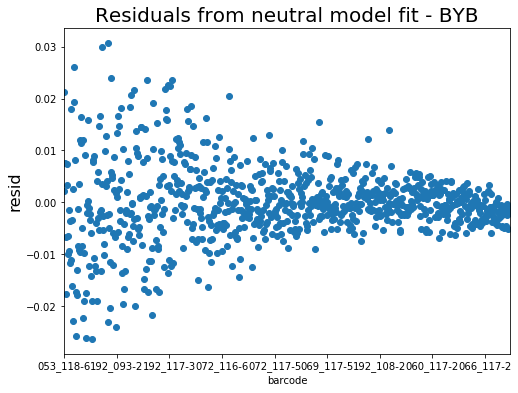

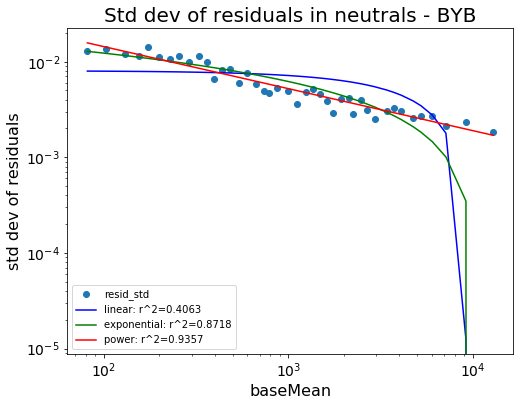

Selected model for BYB: power
Formula: np.log(resid_std) ~ np.log(baseMean)


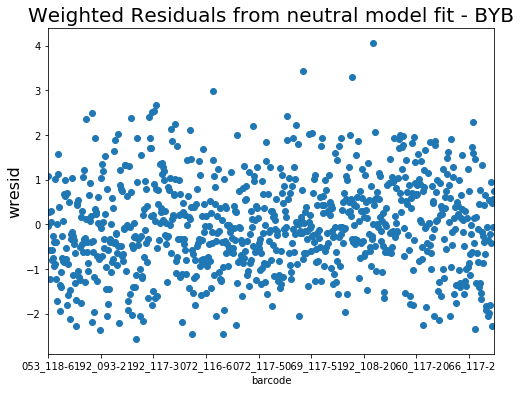

Modeling neutral barcodes in RM


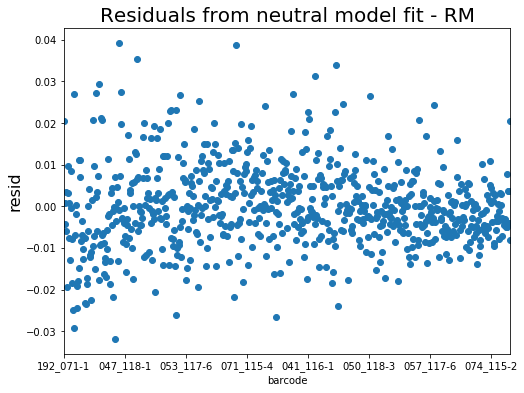

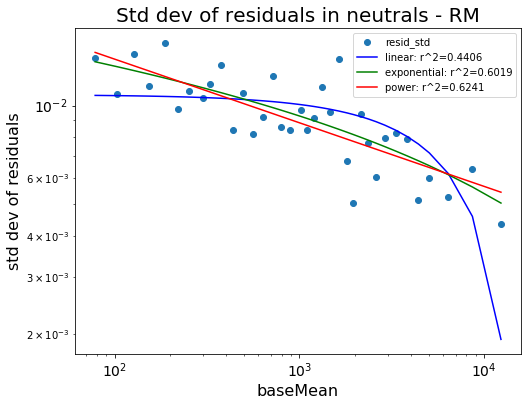

Selected model for RM: power
Formula: np.log(resid_std) ~ np.log(baseMean)


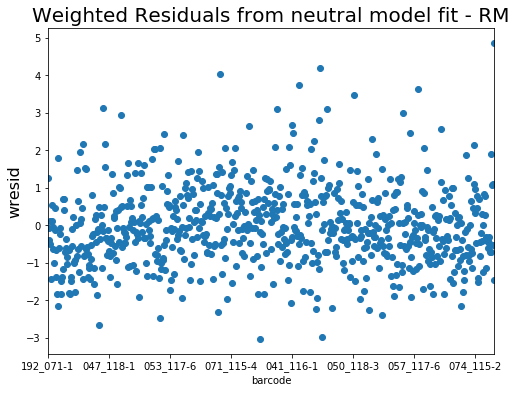

Modeling neutral barcodes in YJM


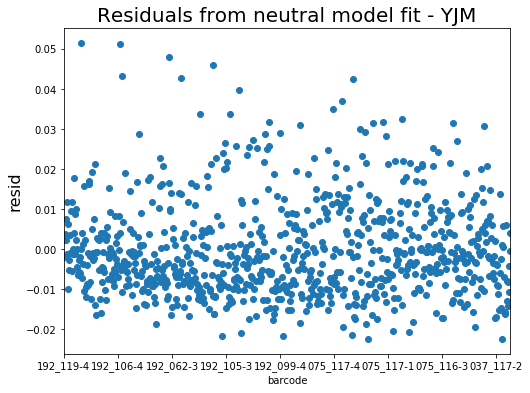

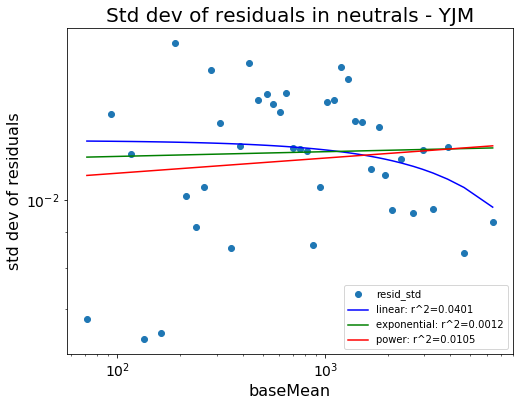

Selected model for YJM: linear
Formula: resid_std ~ baseMean


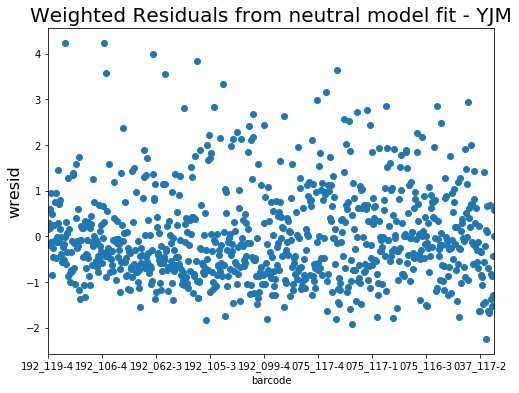

Modeling neutral barcodes in YPS


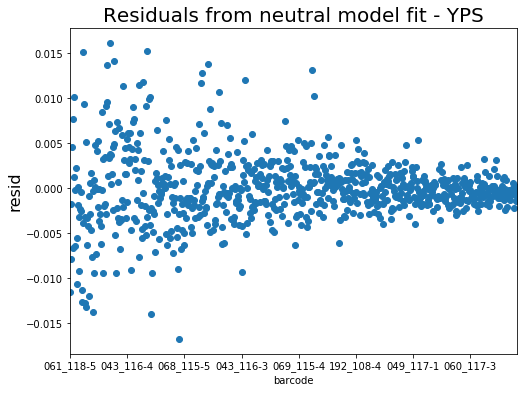

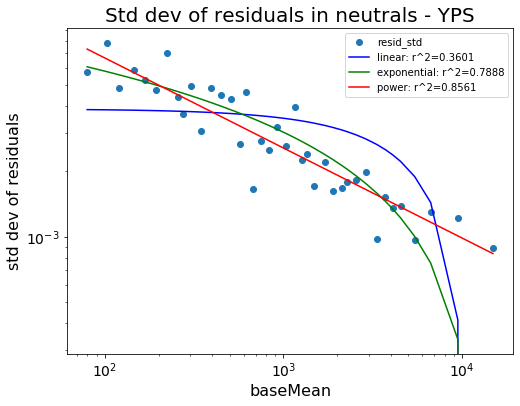

Selected model for YPS: power
Formula: np.log(resid_std) ~ np.log(baseMean)


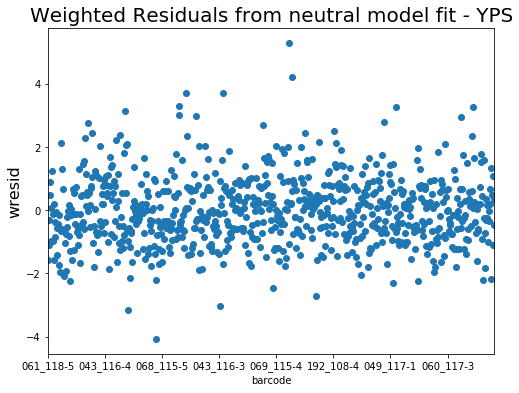

In [11]:
neutral_variance_model_dict = {}

for g, d_neutral in deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)').groupby('geno'):
    print('Modeling neutral barcodes in {}'.format(g))
#     # plot neutral distribution
#     fig, ax = plt.subplots(figsize=(8,6))
#     ax.scatter(d_neutral['baseMean'], d_neutral['log2FoldChange'])
#     ax.set_xlabel('baseMean', fontsize=16)
#     ax.set_ylabel('logFC', fontsize=16)
#     ax.set_title('Neutral barcodes for {}'.format(g), fontsize=20)
#     plt.xticks(fontsize = 14)
#     plt.yticks(fontsize = 14)
#     plt.xscale('log')
#     plt.show()

    # fit OLS
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = ols(formula, d_neutral).fit()

    # plot residuals
    residuals = neutral_model.resid[d_neutral.sort_values('baseMean').index]
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('resid', fontsize=16)
    ax.set_title('Residuals from neutral model fit - {}'.format(g), fontsize=20)
    plt.show()

    # calculate standard deviations of residuals using rolling window of 20 barcodes
    window = 20
    residual_stds_df = pd.DataFrame.from_dict({'baseMean':d_neutral.sort_values('baseMean')['baseMean'].rolling(window).mean()[window-1::window],
                                               'resid_std':residuals.rolling(window).std()[window-1::window]})
    # find best fit for std deviation of residuals 
    fitted_models = {'linear' : ols(formula='resid_std ~ baseMean', data=residual_stds_df).fit(), 
                     'exponential' : ols(formula='resid_std ~ np.log(baseMean)', data=residual_stds_df).fit(), 
                     'power' : ols(formula='np.log(resid_std) ~ np.log(baseMean)', data=residual_stds_df).fit()}

    # plot std dev of residuals and fitted models
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot('baseMean', 'resid_std', data=residual_stds_df, marker='o', linestyle='')
    ax.plot(residual_stds_df['baseMean'], fitted_models['linear'].fittedvalues, 'b-', label='linear: r^2={:.4f}'.format(fitted_models['linear'].rsquared))
    ax.plot(residual_stds_df['baseMean'], fitted_models['exponential'].fittedvalues, 'g-', label='exponential: r^2={:.4f}'.format(fitted_models['exponential'].rsquared))
    ax.plot(residual_stds_df['baseMean'], np.exp(fitted_models['power'].fittedvalues), 'r-', label='power: r^2={:.4f}'.format(fitted_models['power'].rsquared))
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('std dev of residuals', fontsize=16)
    ax.set_title('Std dev of residuals in neutrals - {}'.format(g), fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # select model with best fit
    best_fit = max(fitted_models, key=lambda x: fitted_models[x].rsquared)
    print("Selected model for {}: {}".format(g, best_fit))
    std_model = fitted_models[best_fit]
    print("Formula:", std_model.model.formula)
#     display(std_model.summary())
    
    # calculate (inverse variance) weights based on fitted model, 
    if best_fit == "power":
        w = 1/np.exp(std_model.predict(d_neutral['baseMean']))**2
    else:
        w = 1/std_model.predict(d_neutral['baseMean'])**2

    # refit neutrals in WLS and inspect residuals
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = wls(formula, d_neutral, weights=w).fit()
    residuals = neutral_model.wresid[d_neutral.sort_values('baseMean').index]
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('wresid', fontsize=16)
    ax.set_title('Weighted Residuals from neutral model fit - {}'.format(g), fontsize=20)
    plt.show()
    
    # store neutral model
    neutral_variance_model_dict[g] = (best_fit, std_model)

## Fit DESeq2 results into weighted least squares regression

In [12]:
# prepare input data
d = deseq_results_df.copy()
d.loc[d['barcode_id'].isin(neutral_barcodes_df.index), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference

# calculate weights using neutral models
d['weight'] = 1
for g in d['geno'].unique():
    fit_type, neutral_model = neutral_variance_model_dict[g]
    if fit_type == "power":
        d.loc[d['geno']==g, 'weight'] = 1 / np.exp(neutral_model.predict(d.loc[d['geno']==g]))**2
    else:
        d.loc[d['geno']==g, 'weight'] = 1 / neutral_model.predict(d.loc[d['geno']==g])**2
        
# for each oligo not in neutral set, set its associated barcodes' weights to the median weight
median_weights = d.loc[d['var_id']!=".NEUTRAL"].groupby(['geno', 'barcode_id'])['weight'].median()
d.loc[d['var_id']!=".NEUTRAL", "weight"] = d.loc[d['var_id']!=".NEUTRAL"].apply(lambda x: median_weights.loc[(x.geno, x.barcode_id)], axis=1)

In [13]:
# fit WLS
formula = 'log2FoldChange ~ C(var_id) + C(geno) + C(var_id):C(geno)'
wls_res = wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./models/gxg_5comp_WLSupdated_summary.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()

/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Calculate variant fitness from WLS model
Use calc_var_fitness to extract the fitness values from WLS model. It can also calculate fitness in non-reference conditions by supplying the appropriate terms in the "conditions" variable.

In [14]:
var_dict = dict(d.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby('var_id').apply(lambda x: list(x.geno.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, geno_list) for var, geno_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'geno'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

# write to file
var_fitness_df.to_csv(var_fitness_file, sep='\t', header=True)

,var_id,geno,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
8316,hdr_10,BYA,-8.667582e-02,0.001521,-56.969554,0.000000,-0.089658,-0.083694,0.000000
8408,hdr_30,BYB,-4.332281e-02,0.000895,-48.384648,0.000000,-0.045078,-0.041568,0.000000
8317,hdr_10,BYB,-9.381340e-02,0.001492,-62.889994,0.000000,-0.096737,-0.090890,0.000000
8320,hdr_10,YPS,-6.641331e-02,0.001169,-56.792094,0.000000,-0.068705,-0.064121,0.000000
8407,hdr_30,BYA,-4.660351e-02,0.001033,-45.136491,0.000000,-0.048627,-0.044580,0.000000
...,...,...,...,...,...,...,...,...,...
4732,GXG_30445,YJM,-2.908051e-06,0.003716,-0.000783,0.999376,-0.007286,0.007280,0.999838
52,GXG_00346,BYA,5.574323e-06,0.005080,0.001097,0.999125,-0.009952,0.009963,0.999838
1411,GXG_06810,YJM,-1.878963e-06,0.003828,-0.000491,0.999608,-0.007505,0.007501,0.999838
8115,GXG_49945,RM,-8.944917e-07,0.008113,-0.000110,0.999912,-0.015902,0.015900,0.999947


## Calculate GxG interactions from WLS model
Use calc_cond_interactions to calculate interaction terms between conditions (e.g. genotype, environment, etc.) in WLS model. It calculates all pairwise interactions between conditions supplied in the "conditions" variable.

In [15]:
var_dict = dict(d.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby('var_id').apply(lambda x: list(x.geno.unique())) )
gxg_df = pd.concat([calc_cond_interactions(var, wls_res, geno_list) for var, geno_list in var_dict.items() if len(geno_list)>=2], join='inner', axis=0)

# # adjust formatting
gxg_df.index = pd.MultiIndex.from_tuples(gxg_df.index.str.split(':').tolist(), names=['var_id', 'gxg'])
gxg_df = gxg_df.reset_index()
# calc padj
gxg_df = gxg_df.rename(columns={'P>|t|': 'pval'})
gxg_df['padj'] = multipletests(gxg_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(gxg_df.sort_values('padj'))

# write to file
gxg_df.to_csv(gxg_interactions_file, sep='\t', header=True)

,var_id,gxg,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
15810,hdr_16,BYB-YJM,-0.057286,0.001384,-41.377615,0.000000e+00,-0.059999,-0.054572,0.000000e+00
15928,hdr_30,BYA-YPS,-0.059921,0.001098,-54.550004,0.000000e+00,-0.062074,-0.057768,0.000000e+00
15931,hdr_30,BYB-YPS,-0.056640,0.000971,-58.349763,0.000000e+00,-0.058543,-0.054738,0.000000e+00
15807,hdr_16,BYA-YJM,-0.058856,0.001460,-40.321239,0.000000e+00,-0.061717,-0.055995,0.000000e+00
15811,hdr_16,BYB-YPS,-0.034182,0.000942,-36.274675,6.204513e-286,-0.036029,-0.032336,2.047117e-282
...,...,...,...,...,...,...,...,...,...
14005,GXG_46462,BYB-RM,0.000003,0.002455,0.001330,9.989385e-01,-0.004808,0.004815,9.991808e-01
5702,GXG_18758,BYA-YJM,-0.000006,0.004754,-0.001162,9.990729e-01,-0.009324,0.009313,9.992546e-01
2918,GXG_07390,BYA-YJM,-0.000005,0.004672,-0.000966,9.992296e-01,-0.009162,0.009153,9.993508e-01
14324,GXG_46758,BYA-YJM,-0.000002,0.007045,-0.000313,9.997500e-01,-0.013810,0.013805,9.998106e-01


# Independent replicates of CRISPEY competitions can be jointly analyzed under the same condition label.
In this scenario, barcodes from two independent BY competitions are merged under a common BY label and fitted in the WLS model to obtain BY fitness and GxG interaction estimates. The neutral barcode distribution from both BY competitions were inspected and no significant differences were observed between them. This, combined with the strong correlation between BYA and BYB fitness estimates (obtained from previous model above) provides strong justification for its joint analysis.

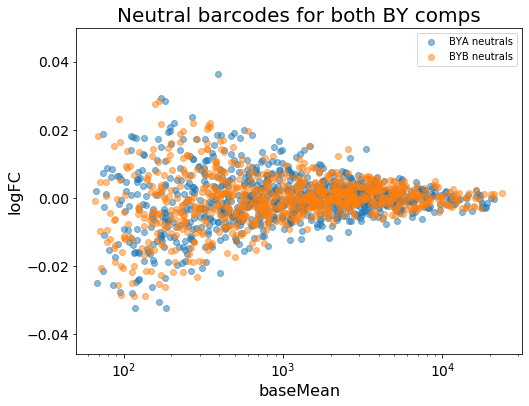

MannwhitneyuResult(statistic=361998.0, pvalue=0.3206225598638728)

In [13]:
# plot neutral distributions for both
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter('baseMean', 'log2FoldChange', data=deseq_results_df.query('geno=="BYA" & barcode_id.isin(@neutral_barcodes_df.index)'), label="BYA neutrals", alpha=0.5)
ax.scatter('baseMean', 'log2FoldChange', data=deseq_results_df.query('geno=="BYB" & barcode_id.isin(@neutral_barcodes_df.index)'), label="BYB neutrals", alpha=0.5)
ax.set_xlabel('baseMean', fontsize=16)
ax.set_ylabel('logFC', fontsize=16)
ax.set_title('Neutral barcodes for both BY comps', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xscale('log')
plt.legend()
plt.show()

# are the two distributions different?
display(mannwhitneyu(deseq_results_df.query('geno=="BYA" & barcode_id.isin(@neutral_barcodes_df.index)').log2FoldChange, 
                     deseq_results_df.query('geno=="BYB" & barcode_id.isin(@neutral_barcodes_df.index)').log2FoldChange))

## Model log2FoldChange variance in BY neutral barcodes jointly

Modeling neutral barcodes for both BY competitions


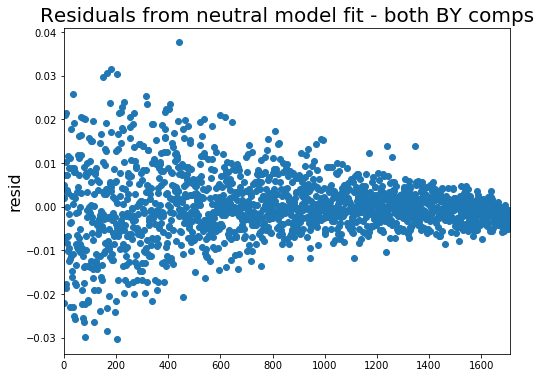

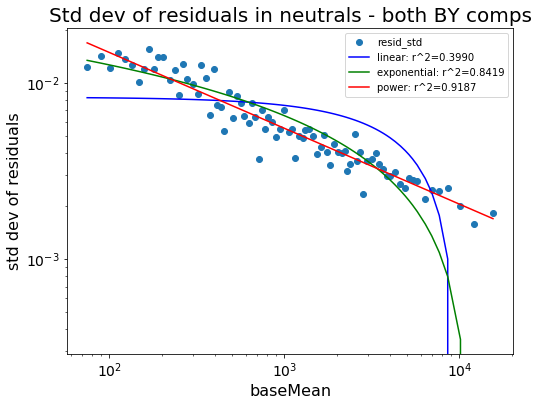

Selected model for YPS: power
Formula: np.log(resid_std) ~ np.log(baseMean)


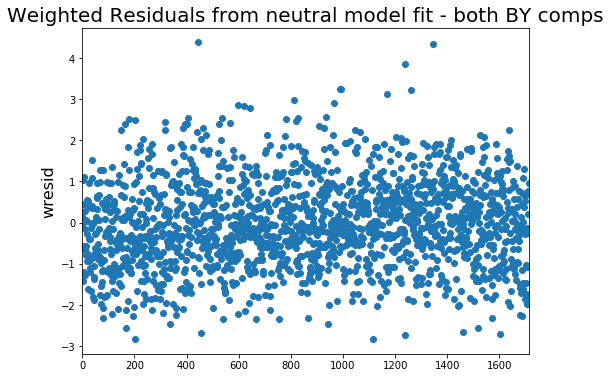

In [14]:
# remodel neutral barcodes for BYA and BYB jointly to update weights
print('Modeling neutral barcodes for both BY competitions')
d_neutral = deseq_results_df.query('(geno=="BYA" | geno=="BYB") & barcode_id.isin(@neutral_barcodes_df.index)').sort_values('baseMean').reset_index().copy()

# fit OLS
formula = 'log2FoldChange ~ np.log(baseMean)'
neutral_model = ols(formula, d_neutral).fit()

# plot residuals
residuals = neutral_model.resid
fig, ax = plt.subplots(figsize=(8,6))
residuals.plot(ax=ax, marker='o', linestyle='')
ax.set_ylabel('resid', fontsize=16)
ax.set_title('Residuals from neutral model fit - both BY comps', fontsize=20)
plt.show()

# calculate standard deviations of residuals using rolling window of 20 barcodes
window = 20
residual_stds_df = pd.DataFrame.from_dict({'baseMean':d_neutral['baseMean'].rolling(window).mean()[window-1::window],
                                           'resid_std':residuals.rolling(window).std()[window-1::window]})
# find best fit for std deviation of residuals 
fitted_models = {'linear' : ols(formula='resid_std ~ baseMean', data=residual_stds_df).fit(), 
                 'exponential' : ols(formula='resid_std ~ np.log(baseMean)', data=residual_stds_df).fit(), 
                 'power' : ols(formula='np.log(resid_std) ~ np.log(baseMean)', data=residual_stds_df).fit()}

# plot std dev of residuals and fitted models
fig, ax = plt.subplots(figsize=(8,6))
ax.plot('baseMean', 'resid_std', data=residual_stds_df, marker='o', linestyle='')
ax.plot(residual_stds_df['baseMean'], fitted_models['linear'].fittedvalues, 'b-', label='linear: r^2={:.4f}'.format(fitted_models['linear'].rsquared))
ax.plot(residual_stds_df['baseMean'], fitted_models['exponential'].fittedvalues, 'g-', label='exponential: r^2={:.4f}'.format(fitted_models['exponential'].rsquared))
ax.plot(residual_stds_df['baseMean'], np.exp(fitted_models['power'].fittedvalues), 'r-', label='power: r^2={:.4f}'.format(fitted_models['power'].rsquared))
ax.set_xlabel('baseMean', fontsize=16)
ax.set_ylabel('std dev of residuals', fontsize=16)
ax.set_title('Std dev of residuals in neutrals - both BY comps', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# select model with best fit
best_fit = max(fitted_models, key=lambda x: fitted_models[x].rsquared)
print("Selected model for {}: {}".format(g, best_fit))
std_model = fitted_models[best_fit]
print("Formula:", std_model.model.formula)
#     display(std_model.summary())

# calculate (inverse variance) weights based on fitted model, 
if best_fit == "power":
    w = 1/np.exp(std_model.predict(d_neutral['baseMean']))**2
else:
    w = 1/std_model.predict(d_neutral['baseMean'])**2

# refit neutrals in WLS and inspect residuals
formula = 'log2FoldChange ~ np.log(baseMean)'
neutral_model = wls(formula, d_neutral, weights=w).fit()
residuals = neutral_model.wresid[d_neutral.sort_values('baseMean').index]
fig, ax = plt.subplots(figsize=(8,6))
residuals.plot(ax=ax, marker='o', linestyle='')
ax.set_ylabel('wresid', fontsize=16)
ax.set_title('Weighted Residuals from neutral model fit - both BY comps', fontsize=20)
plt.show()

# store neutral model
neutral_variance_model_dict["BY"] = (best_fit, std_model)

## Fit DESeq2 results into weighted least squares regression

In [15]:
# prepare input data
d = deseq_results_df.copy()
d.loc[d['barcode_id'].isin(neutral_barcodes_df.index), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference
# set BYA and BYB geno labels to BY
d['geno'] = d['geno'].replace({'BYA':'BY', 'BYB':'BY'})

# calculate weights using neutral models
d['weight'] = 1
for g in d['geno'].unique():
    fit_type, neutral_model = neutral_variance_model_dict[g]
    if fit_type == "power":
        d.loc[d['geno']==g, 'weight'] = 1 / np.exp(neutral_model.predict(d.loc[d['geno']==g]))**2
    else:
        d.loc[d['geno']==g, 'weight'] = 1 / neutral_model.predict(d.loc[d['geno']==g])**2
        
# for each oligo not in neutral set, set its associated barcodes' weights to the median weight
median_weights = d.loc[d['var_id']!=".NEUTRAL"].groupby(['geno', 'barcode_id'])['weight'].median()
d.loc[d['var_id']!=".NEUTRAL", "weight"] = d.loc[d['var_id']!=".NEUTRAL"].apply(lambda x: median_weights.loc[(x.geno, x.barcode_id)], axis=1)

In [16]:
# fit WLS
formula = 'log2FoldChange ~ C(var_id) + C(geno) + C(var_id):C(geno)'
wls_res = wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./models/gxg_5comp_WLSupdated_jointBY_summary.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()

/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Calculate variant fitness and GxG interactions for 4 strains

In [17]:
var_fitness_file = output_dir+"gxg_5comp_aug2021_varFitness_WLSupdated_jointBY.txt"
gxg_interactions_file = output_dir+"gxg_5comp_aug2021_gxgInteractions_WLSupdated_jointBY.txt"

In [18]:
var_dict = dict(d.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby('var_id').apply(lambda x: list(x.geno.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, geno_list) for var, geno_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'geno'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

# write to file
var_fitness_df.to_csv(var_fitness_file, sep='\t', header=True)

,var_id,geno,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
6682,hdr_10,BY,-9.017636e-02,0.001059,-85.119232,0.000000e+00,-0.092253,-0.088100,0.000000e+00
6703,hdr_16,BY,-2.686511e-02,0.000671,-40.029036,0.000000e+00,-0.028181,-0.025550,0.000000e+00
6685,hdr_10,YPS,-6.641331e-02,0.001173,-56.596307,0.000000e+00,-0.068713,-0.064113,0.000000e+00
6755,hdr_30,BY,-4.470956e-02,0.000678,-65.915474,0.000000e+00,-0.046039,-0.043380,0.000000e+00
6758,hdr_30,YPS,1.331732e-02,0.000376,35.400171,1.490675e-272,0.012580,0.014055,2.090225e-269
...,...,...,...,...,...,...,...,...,...
3802,GXG_30445,YJM,-2.908051e-06,0.003729,-0.000780,9.993777e-01,-0.007311,0.007305,9.998949e-01
2937,GXG_21944,RM,1.840483e-06,0.002962,0.000621,9.995042e-01,-0.005804,0.005807,9.998949e-01
1132,GXG_06810,YJM,-1.878963e-06,0.003841,-0.000489,9.996097e-01,-0.007531,0.007527,9.998949e-01
6519,GXG_49945,RM,-8.944917e-07,0.008141,-0.000110,9.999123e-01,-0.015957,0.015955,9.999472e-01


In [19]:
var_dict = dict(d.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby('var_id').apply(lambda x: list(x.geno.unique())) )
gxg_df = pd.concat([calc_cond_interactions(var, wls_res, geno_list) for var, geno_list in var_dict.items() if len(geno_list)>=2], join='inner', axis=0)

# # adjust formatting
gxg_df.index = pd.MultiIndex.from_tuples(gxg_df.index.str.split(':').tolist(), names=['var_id', 'gxg'])
gxg_df = gxg_df.reset_index()
# calc padj
gxg_df = gxg_df.rename(columns={'P>|t|': 'pval'})
gxg_df['padj'] = multipletests(gxg_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(gxg_df.sort_values('padj'))

# write to file
gxg_df.to_csv(gxg_interactions_file, sep='\t', header=True)

,var_id,gxg,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
9470,hdr_16,BY-YJM,-5.809058e-02,0.001259,-46.142884,0.000000e+00,-0.060558,-0.055623,0.000000e+00
9471,hdr_16,BY-YPS,-3.498728e-02,0.000741,-47.219519,0.000000e+00,-0.036440,-0.033535,0.000000e+00
9542,hdr_30,BY-YPS,-5.802688e-02,0.000776,-74.813075,0.000000e+00,-0.059547,-0.056507,0.000000e+00
9541,hdr_30,BY-YJM,-6.889323e-02,0.002233,-30.856742,6.067735e-208,-0.073269,-0.064517,1.499186e-204
9442,hdr_10,BY-YJM,-9.499951e-02,0.003194,-29.746180,1.823259e-193,-0.101259,-0.088740,3.603853e-190
...,...,...,...,...,...,...,...,...,...
8579,GXG_46758,BY-YJM,-5.930705e-06,0.006062,-0.000978,9.992194e-01,-0.011887,0.011875,9.995635e-01
6287,GXG_34150,BY-YPS,-2.588522e-06,0.002791,-0.000927,9.992601e-01,-0.005473,0.005468,9.995635e-01
2843,GXG_14800,BY-RM,2.952920e-06,0.003761,0.000785,9.993736e-01,-0.007369,0.007375,9.995759e-01
9190,GXG_49786,BY-YJM,4.430047e-06,0.007348,0.000603,9.995189e-01,-0.014397,0.014406,9.996201e-01


## (optional) Estimate fitness per oligo
Oligo-specific fitness effects can be calculated by using "barcode_id" instead of "var_id" in the WLS formula when fitting

In [16]:
oligo_fitness_file = output_dir+"gxg_5comp_aug2021_oligoFitness_WLSupdated.txt"

In [17]:
# prepare input data
d = deseq_results_df.copy()
d.loc[d['barcode_id'].isin(neutral_barcodes_df.index), 'barcode_id'] = '000_000' # sets neutral barcodes as reference

# fit WLS
formula = 'log2FoldChange ~ C(barcode_id) + C(geno) + C(barcode_id):C(geno)' # includes interaction term with condition of interest

wls_res = wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./models/gxg_5comp_WLSupdated_summary_oligo.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()

In [19]:
# calculate oligo fitness
oligo_dict = dict(d.query('barcode_id!="000_000"').groupby('barcode_id').apply(lambda x: list(x.geno.unique())) )
oligo_fitness_df = pd.concat([calc_var_fitness(oligo, wls_res, geno_list) for oligo, geno_list in oligo_dict.items()], join='inner', axis=0)

# adjust formatting
oligo_fitness_df.index = pd.MultiIndex.from_tuples(oligo_fitness_df.index.str.split(',').tolist(), names=['barcode_id', 'geno'])
oligo_fitness_df = oligo_fitness_df.reset_index()
# calc padj
oligo_fitness_df = oligo_fitness_df.rename(columns={'P>|t|': 'pval'})
oligo_fitness_df['padj'] = multipletests(oligo_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(oligo_fitness_df.sort_values('padj'))

# write to file
oligo_fitness_df.to_csv(oligo_fitness_file, sep='\t', header=True)

,barcode_id,geno,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
15682,074_120,BYB,-8.633417e-02,0.002348,-36.776196,1.604271e-293,-0.090935,-0.081733,2.758865e-289
10856,062_121,BYB,-9.512517e-02,0.002662,-35.731279,2.470875e-277,-0.100343,-0.089907,2.124582e-273
15685,074_120,YPS,-6.286349e-02,0.001789,-35.142256,2.085643e-268,-0.066370,-0.059357,1.195560e-264
5280,048_121,BYA,-9.780532e-02,0.002799,-34.947214,1.751439e-265,-0.103291,-0.092320,7.529872e-262
5281,048_121,BYB,-9.940715e-02,0.002914,-34.119279,3.026151e-253,-0.105118,-0.093697,1.040814e-249
...,...,...,...,...,...,...,...,...,...
4032,045_103,RM,2.316574e-06,0.003549,0.000653,9.994793e-01,-0.006955,0.006959,9.998245e-01
11405,064_042,RM,1.840483e-06,0.002835,0.000649,9.994821e-01,-0.005555,0.005559,9.998245e-01
9967,060_087,YPS,-1.551993e-06,0.004244,-0.000366,9.997082e-01,-0.008319,0.008316,9.998245e-01
7978,055_080,BYB,4.798599e-07,0.004046,0.000119,9.999054e-01,-0.007929,0.007930,9.999084e-01


### If estimating oligo-level GxG interactions is not required, separate models may be fitted for each condition.

In [16]:
oligo_fitness_file = output_dir+"gxg_5comp_aug2021_oligoFitness_WLSupdated_splitmodel.txt"

In [17]:
# prepare input data
d = deseq_results_df.copy()
d.loc[d['barcode_id'].isin(neutral_barcodes_df.index), 'barcode_id'] = '000_000' # sets neutral barcodes as reference

# split model approach
geno_oligo_models = {}
for g, d_sub in d.groupby('geno'):
    # fit WLS
    formula = 'log2FoldChange ~ C(barcode_id)'
    wls_res = wls(formula, data=d_sub, weights=d_sub['weight']).fit()
    geno_oligo_models[g] = wls_res

    # write WLS model summary table to file
    file = open("./models/gxg_5comp_WLSupdated_summary_oligo_{}.txt".format(g), "w")
    file.write(wls_res.summary().as_csv())
    file.close()

In [18]:
# calculate oligo fitness from each model, assemble complete dataframe
oligo_fitness_df = []
for g, d_sub in d.groupby('geno'):
    oligo_dict = dict(d_sub.query('barcode_id!="000_000"').groupby('barcode_id').apply(lambda x: list(x.geno.unique())) )
    df = pd.concat([calc_var_fitness(oligo, geno_oligo_models[g], geno_list) for oligo, geno_list in oligo_dict.items()], join='inner', axis=0)
    oligo_fitness_df.append(df)

oligo_fitness_df = pd.concat(oligo_fitness_df)
# adjust formatting
oligo_fitness_df.index = pd.MultiIndex.from_tuples(oligo_fitness_df.index.str.split(',').tolist(), names=['barcode_id', 'geno'])
oligo_fitness_df = oligo_fitness_df.reset_index()
# calc padj
oligo_fitness_df = oligo_fitness_df.rename(columns={'P>|t|': 'pval'})
oligo_fitness_df['padj'] = multipletests(oligo_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(oligo_fitness_df.sort_values('padj'))

# write to file
oligo_fitness_df.to_csv(oligo_fitness_file, sep='\t', header=True)

,barcode_id,geno,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
1073,048_121,BYA,-9.780532e-02,0.002671,-36.618325,5.580086e-282,-0.103041,-0.092570,4.798037e-278
6620,074_120,BYB,-8.633417e-02,0.002356,-36.646627,3.569344e-282,-0.090952,-0.081716,4.798037e-278
5666,062_121,BYB,-9.512517e-02,0.002672,-35.605392,4.412973e-267,-0.100362,-0.089888,2.529663e-263
4549,048_121,BYB,-9.940715e-02,0.002924,-33.999071,1.584552e-244,-0.105138,-0.093676,6.812387e-241
16910,074_120,YPS,-6.286349e-02,0.001909,-32.926682,4.523769e-229,-0.066606,-0.059121,1.555905e-225
...,...,...,...,...,...,...,...,...,...
15842,060_087,YPS,-1.551993e-06,0.004529,-0.000343,9.997266e-01,-0.008879,0.008876,9.998429e-01
12393,061_065,YJM,2.322441e-06,0.005514,0.000421,9.996640e-01,-0.010806,0.010811,9.998429e-01
9001,064_042,RM,1.840483e-06,0.002466,0.000746,9.994045e-01,-0.004832,0.004836,9.998429e-01
9041,064_116,RM,-8.944917e-07,0.006778,-0.000132,9.998947e-01,-0.013287,0.013285,9.999057e-01
